# Attentive LSTM on Synthetic images

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tensorflow

import numpy as np
import matplotlib.pyplot as plt

from builder import *
import att_utils

import keras
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, TimeDistributed, Reshape, Flatten
from keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from keras.layers.merge import multiply, add, concatenate, dot
from keras.regularizers import l1, l2
from keras import backend as K

import recurrentshop
from recurrentshop.cells import LSTMCell
from recurrentshop import RecurrentModel
from recurrentshop.engine import _OptionalInputPlaceHolder
from keras.layers.convolutional import Conv1D

from keras.models import load_model

/Users/bychkov/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:

 This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.


Using TensorFlow backend.


In [3]:
step_size = 35
tile_size = 40

data_dict = att_utils.load_synthetic_imgs('synthetic_imgs/test.npz')
data_dict = att_utils.extract_tiles(data_dict, tile_size, step_size)

### Define a model:

In [6]:
# --- Main input --
input_patche_seq = Input(shape=(None,tile_size,tile_size,3), name='input_patche_seq')

# --- Inception ---
input_img = Input(shape=(tile_size, tile_size, 3), name='input_img')

tow_1_1 = Conv2D(4, (1,1), padding='same', activation='relu', name='t11_c1')(input_img)
tow_1_1 = Conv2D(4, (3,3), padding='same', activation='relu', name='t11_c2')(tow_1_1)

tow_2_1 = Conv2D(4, (1,1), padding='same', activation='relu', name='t21_c1')(input_img)
tow_2_1 = Conv2D(4, (5,5), padding='same', activation='relu', name='t21_c2')(tow_2_1)

tow_3_1 = MaxPooling2D((3,3), strides=(1,1), padding='same', name='t31_mp')(input_img)
tow_3_1 = Conv2D(4, (1,1), padding='same', activation='relu', name='t31_c1')(tow_3_1)

stack_1 = keras.layers.concatenate([tow_1_1, tow_2_1, tow_3_1], axis=3, name='stack_1')

stack_1 = Conv2D(16, (3,3), padding='same', activation='relu')(stack_1)
stack_1 = MaxPooling2D((2,2))(stack_1)


tow_1_2 = Conv2D(8, (1,1), padding='same', activation='relu', name='t12_c1')(stack_1)
tow_1_2 = Conv2D(8, (3,3), padding='same', activation='relu', name='t12_c2')(tow_1_2)

tow_2_2 = Conv2D(8, (1,1), padding='same', activation='relu', name='t22_c1')(stack_1)
tow_2_2 = Conv2D(8, (5,5), padding='same', activation='relu', name='t22_c2')(tow_2_2)

tow_3_2 = MaxPooling2D((3,3), strides=(1,1), padding='same', name='t32_mp')(stack_1)
tow_3_2 = Conv2D(8, (1,1), padding='same', activation='relu', name='t32_c1')(tow_3_2)

stack_2 = keras.layers.concatenate([tow_1_2, tow_2_2, tow_3_2], axis=3, name='stack_2')

stack_2 = Conv2D(32, (3,3), padding='same', activation='relu')(stack_2)
stack_2 = MaxPooling2D((2,2))(stack_2)

stack_2 = Conv2D(32, (3,3), padding='same', activation='relu')(stack_2)
stack_2 = MaxPooling2D((2,2))(stack_2)

incpt   = Reshape((25,32))(stack_2)

inception = Model(input_img, incpt)
#inception.summary()

In [7]:
# --- Attentive LSTM ---
K2 = 5*5  # num of locations (within one tile/time-step)
D  = 32  # num of feature maps

attentive_lstm_dim   = 32
attentive_lstm_depth = 2

X_t            = Input((K2,D), name='X_t')
readout_input  = Input((attentive_lstm_dim,), name='readout_input')

h_tm1          = Input((attentive_lstm_dim,), name='h_tm1')
c_tm1          = Input((attentive_lstm_dim,), name='c_tm1')

x_kernel  = Conv1D(filters=1, kernel_size=1, strides=1, activity_regularizer=l2(1.15))
h_kernel  = Dense(K2, activation='linear', activity_regularizer=l2(1.15))

W_xt           = x_kernel(X_t)
W_xt           = Reshape((K2,))(W_xt)
W_ht           = h_kernel(readout_input)

att_scores     = add([W_xt,W_ht])
att_mask       = Activation(K.softmax, name='att_mask')(att_scores)

lstms_input    = dot([att_mask, X_t], axes=(1,1))

cells = [ LSTMCell(attentive_lstm_dim) for _ in range(attentive_lstm_depth) ]

lstms_output, h, c = lstms_input, h_tm1, c_tm1
for cell in cells:
    lstms_output, h, c = cell([lstms_output, h, c])

attentive_lstm = RecurrentModel(input = X_t, output = lstms_output,
                     initial_states    = [h_tm1, c_tm1],
                     final_states      = [h, c],
                     readout_input     = readout_input,
                     return_states     = False,
                     return_sequences  = True)

#--- Full Model ---#
fmap_seq   = TimeDistributed(inception)(input_patche_seq)
lstm_out1  = attentive_lstm(fmap_seq)
lstm_out2  = LSTM(16,  activation='tanh')(lstm_out1)
hazard     = Dense(1, activation='linear')(lstm_out2)

model = Model(input_patche_seq, hazard)
model.compile(loss='mean_squared_error', optimizer='adadelta')
#model.compile(loss=partial_likelihood, optimizer='adadelta')

### Train 

In [36]:
model.fit(
        x           = data_dict['train_x_p'][2000:3000,],
        y           = data_dict['train_y'][2000:3000,0],
        validation_data = (
                data_dict['valid_x_p'][:500,],
                data_dict['valid_y'][:500,0]    ),
        #validation_split = 0.3,
        epochs      = 1,
        batch_size  = 100 )

Train on 1000 samples, validate on 500 samples
Epoch 1/1
1000/1000 [==============================] - 23s - loss: 1.4932 - val_loss: 1.3064


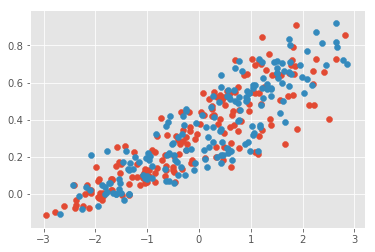

In [37]:
preds = np.squeeze(model.predict( data_dict['train_x_p'][:175,] ))
plt.scatter( data_dict['train_y'][:175, 0], preds )

preds = np.squeeze(model.predict( data_dict['test_x_p'][:175,] ))
plt.scatter( data_dict['test_y'][:175, 0], preds )
#plt.ylim(-3, 3)

### Backend functions to extract attention masks:

In [38]:
cnn_seq  = K.function(
            inputs  = [ model.layers[0].input ],
            outputs = [ model.layers[1].output ] )

att_seq  = K.function(
            inputs  = [ model.layers[0].input ],
            outputs = [ model.layers[5].get_output_at(0) ] )

get_mask = K.function(
        inputs  = [ model.layers[5].model.layers[0].input,
                    model.layers[5].model.layers[2].input ],
        outputs = [ model.layers[5].model.layers[6].output ] )

In [39]:
idx = np.random.randint(low=0, high = 999, size=9)

vis_img     = data_dict['test_x'][idx]

check_imgs  = data_dict['test_x_p'][idx]
fmaps       = cnn_seq( [ check_imgs ] )[0]
hhs         = att_seq( [ check_imgs ] )[0]

print(check_imgs.shape)
print(fmaps.shape)
print(hhs.shape)

num_imgs  = check_imgs.shape[0]
num_tiles = check_imgs.shape[1]
tile_h    = check_imgs.shape[2]
tile_w    = check_imgs.shape[3]
loc_grid  = int( np.sqrt(K2) )

#------------------------------------------------------------
# Iterate over Images:
mask_images = list()
for ind in range(num_imgs):
    tile_lst = list()
    # First tile mask is not available, so just zeros()
    tile_lst.append( np.zeros((loc_grid, loc_grid), dtype='float32') )
    # Iterate over N-1 Tiles:
    for tile in range(1,num_tiles):
        tile_lst.append(
            np.reshape(
                get_mask([ fmaps [ ind, tile:tile+1, ... ] ,
                           hhs [ ind, tile-1:tile, ... ]     ])[0],
                (loc_grid, loc_grid), 'C')
        )

    tiles = np.stack(tile_lst, axis=0)

    upscaled_tiles = att_utils.upscale_mask_tiles(tiles, (tile_h, tile_w))
    mask_images.append(
        att_utils.reconstruct_from_tiles_2d(upscaled_tiles, step_size, (111,111))
    )
masks = np.stack( mask_images, axis=0 )

(9, 9, 40, 40, 3)
(9, 9, 25, 32)
(9, 9, 32)


(9, 111, 111, 3)
(9, 111, 111)


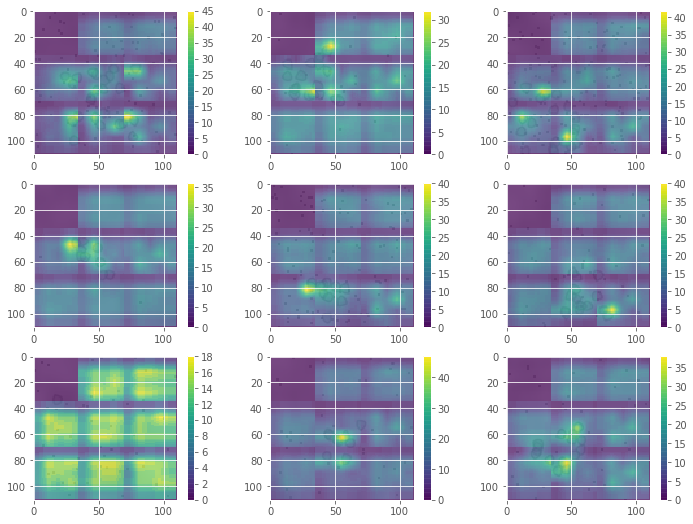

In [40]:
print(vis_img.shape)
print(masks.shape)

# Visualize 2 x 2 Grid:
fig = plt.figure(frameon=False, figsize=(12, 9))
for im_ind in range(9):
    sub_i = 330 + im_ind + 1
    plt.subplot(sub_i)
    plt.imshow(
            att_utils.rgb2gray(vis_img[im_ind]),
            cmap=plt.cm.gray, alpha=0.35 )
    plt.imshow(masks[im_ind], alpha=.7)
    #plt.imshow(masks[im_ind], alpha=.7, vmin=0, vmax=255)
    #print(np.max( masks[im_ind] ))
    plt.colorbar()

36.0


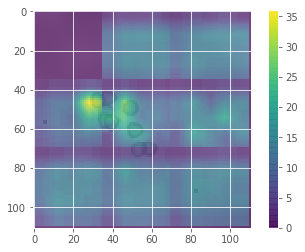

In [48]:
# Plot single image:
im_ind = 3
fig = plt.figure(frameon=False)
plt.imshow( att_utils.rgb2gray(vis_img[im_ind]),
            cmap=plt.cm.gray, alpha=0.5 )
plt.imshow(masks[im_ind], alpha=.7) # vmin=0, vmax=255
print(np.max( masks[im_ind] ))
plt.colorbar()

In [82]:
model.save_weights('models/rec_synthetic_weights.h5')

In [ ]:
model.load_weights('models/attentive_synthetic.h5')